### TFIDF Vectorizer

In [2]:
# import packages

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('news_processed.csv')

In [4]:
df.head()

,title_aft,text_aft,subject,date,target,combined
0,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,News,"December 31, 2017",1,donald trump sends embarrassing new year eve m...
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,News,"December 31, 2017",1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,News,"December 30, 2017",1,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,News,"December 29, 2017",1,trump obsessed even obama name coded website i...
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,News,"December 25, 2017",1,pope francis called donald trump christmas spe...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44266 entries, 0 to 44265
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title_aft  44266 non-null  object
 1   text_aft   44266 non-null  object
 2   subject    44266 non-null  object
 3   date       44266 non-null  object
 4   target     44266 non-null  int64 
 5   combined   44266 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.0+ MB


In [4]:
def combine_title_text(row):
    title = nltk.word_tokenize(row['title_aft'])
    text = nltk.word_tokenize(row['text_aft'])
    words = title + text
    return " ".join(words)

df['combined'] = [combine_title_text(row) for index, row in df.iterrows()]
    

In [33]:
df['combined'].head()

0    donald trump sends embarrassing new year eve m...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama name coded website i...
4    pope francis called donald trump christmas spe...
Name: combined, dtype: object

In [6]:
#Tfidf Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, max_df, min_df):
    
    vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    X = vectorizer.fit_transform(text)
    return X

text = df['combined'].values
X = vectorize(text, 0.9, 0.1)
X.shape


(44266, 232)

Number of components = 2 and explained variance = 0.0645815701120332
Number of components = 4 and explained variance = 0.12019874885016721
Number of components = 10 and explained variance = 0.22136285994609878
Number of components = 15 and explained variance = 0.27774246329009994
Number of components = 20 and explained variance = 0.32287506491227147
Number of components = 50 and explained variance = 0.501860194143755
Number of components = 100 and explained variance = 0.699942701241003
Number of components = 150 and explained variance = 0.8419367558636882
Number of components = 200 and explained variance = 0.9492201120547028
Number of components = 230 and explained variance = 0.9978216630681901


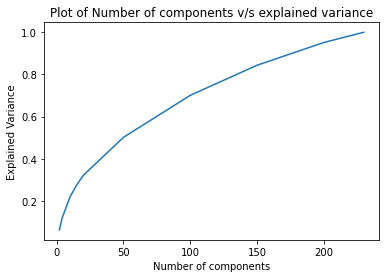

In [12]:
# use SVD for dimensionality reduction so that the data is easier to process

from sklearn.decomposition import TruncatedSVD

n_comp = [2,4,10,15,20,50,100,150,200,230] 
explained = [] 
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit_transform(X.toarray())
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [7]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=42)
X_reduced= svd.fit_transform(X.toarray())
X_reduced.shape

(44266, 200)

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X_reduced, df['target'], test_size = 0.2, random_state=42)

In [21]:
# sample data for fast result in GridSearchCV

x_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

In [22]:
svc = svm.SVC(kernel="rbf")
ranges = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
param_grid = {"C":ranges, "gamma":ranges}

clf = GridSearchCV(svc, param_grid=param_grid, scoring="accuracy", cv=3)
clf.fit(x_train_sample, y_train_sample)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
                         'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10]},
             scoring='accuracy')

In [23]:
print(clf.best_params_)

{'C': 3, 'gamma': 1}


In [10]:
svm = svm.SVC(kernel="rbf", C=3, gamma=1)
svm.fit(X_train, y_train)

SVC(C=3, gamma=1)

In [11]:
# Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score

y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

In [12]:
print('Accuracy score:', acc)
print('F1 score:', f1)
print('Precision:', prec)
print('Recall:', rec)

Accuracy score: 0.9876891800316241
F1 score: 0.9880626437411018
Precision: 0.988387379491674
Recall: 0.9877381213050143


In [13]:
# save model

import pickle

pickle.dump(svm, open('svm_tfidf.p', 'wb'))

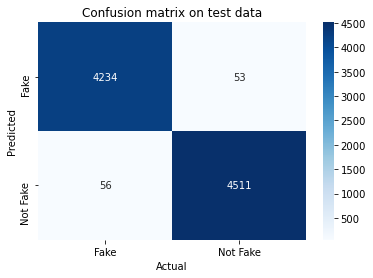

In [18]:
# plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import seaborn as sns

cm = pd.DataFrame(confusion_matrix(y_test , y_pred) , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Fake','Not Fake'], yticklabels = ['Fake','Not Fake'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.savefig('cf_tfidf_svm.jpg')
plt.show()

### Word2Vec 

#### Data Preprocessing

In [25]:
df1 = pd.read_csv('Fake.csv')
df2 = pd.read_csv('True.csv')

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [27]:
df1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [28]:
df2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [29]:
df1['target'] = [1 for i in range(len(df1))]
df2['target'] = [0 for i in range(len(df2))]

In [30]:
df_tot = pd.concat([df1, df2])

In [31]:
df_tot = df_tot.replace(r'^\s*$', np.NaN, regex=True)

In [32]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44267 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [33]:
df_tot = df_tot.dropna()

In [34]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44267 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44267 non-null  object
 1   text     44267 non-null  object
 2   subject  44267 non-null  object
 3   date     44267 non-null  object
 4   target   44267 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [35]:
df_tot = df_tot.reset_index()
df_tot = df_tot.drop('index', axis=1)

In [36]:
df_tot['combined'] = df_tot['title'] + '. ' + df_tot['text']

In [37]:
# clean sentence of each new
import re
from nltk.corpus import stopwords 

def news_wordlist(new, remove_stopwords=False):
    new = re.sub("[^a-zA-Z]"," ", new)
    words = new.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops] 
    return (words) 

In [38]:
# get clean news

def news_sentences(new, remove_stopwords=False):
   
    raw_sentences = nltk.sent_tokenize(new.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(news_wordlist(raw_sentence, remove_stopwords))

    # This returns the list of lists
    return sentences

sentences = []

for new in df_tot["combined"]:
    sentences += news_sentences(new)

In [39]:
words = []
for new in df_tot["combined"]:
    raw_sentences = nltk.sent_tokenize(new.strip())
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            words += news_wordlist(raw_sentence, remove_stopwords=False)

In [40]:
len(set(words))

115945

#### Model

In [41]:
#Word2Vec model
num_features = 100  
min_word_count = 40
num_workers = 4     
context = 10        
downsampling = 1e-3 

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "word2vec_model"
model.save(model_name)

Training model....


In [42]:
# Function to average all word vectors in a paragraph
def feature_vec_method(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    feature_vec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            feature_vec = np.add(feature_vec, model[word])
    
    # Dividing the result by number of words to get average
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

In [43]:
# Function for calculating the average feature vector
def get_avg_feature_vecs(news, model, num_features):
    counter = 0
    news_feature_vecs = np.zeros((len(news), num_features),dtype="float32")
    for new in news:
        if counter%1000 == 0:
            print("News %d of %d"%(counter,len(news)))
            
        news_feature_vecs[counter] = feature_vec_method(new, model, num_features)
        counter = counter+1
        
    return news_feature_vecs

In [44]:
df_tot = df_tot.reset_index()

In [45]:
df_tot = df_tot.drop('index', axis=1)

In [46]:
X = df_tot[['combined']]
y = df_tot['target']

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [48]:
# Calculating average feature vector for training set
clean_train_news = []
for new in X_train['combined']:
    clean_train_news.append(news_wordlist(new, remove_stopwords=True))
    
train_data_vecs = get_avg_feature_vecs(clean_train_news, model, num_features)

News 0 of 35413


<ipython-input-42-38207aae0b4e>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vec = np.add(feature_vec, model[word])


News 1000 of 35413
News 2000 of 35413
News 3000 of 35413
News 4000 of 35413
News 5000 of 35413
News 6000 of 35413
News 7000 of 35413
News 8000 of 35413
News 9000 of 35413
News 10000 of 35413
News 11000 of 35413
News 12000 of 35413
News 13000 of 35413
News 14000 of 35413
News 15000 of 35413
News 16000 of 35413
News 17000 of 35413
News 18000 of 35413
News 19000 of 35413
News 20000 of 35413
News 21000 of 35413
News 22000 of 35413
News 23000 of 35413
News 24000 of 35413
News 25000 of 35413
News 26000 of 35413
News 27000 of 35413
News 28000 of 35413
News 29000 of 35413
News 30000 of 35413
News 31000 of 35413
News 32000 of 35413
News 33000 of 35413
News 34000 of 35413
News 35000 of 35413


In [49]:
# Calculating average feature vactors for test set     
clean_test_news = []
for new in X_test["combined"]:
    clean_test_news.append(news_wordlist(new, remove_stopwords=True))
    
test_data_vecs = get_avg_feature_vecs(clean_test_news, model, num_features)

News 0 of 8854


<ipython-input-42-38207aae0b4e>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vec = np.add(feature_vec, model[word])


News 1000 of 8854
News 2000 of 8854
News 3000 of 8854
News 4000 of 8854
News 5000 of 8854
News 6000 of 8854
News 7000 of 8854
News 8000 of 8854


In [47]:
# sample for faster result in GridSerachCV

x_train_sample = train_data_vecs[:10000]
y_train_sample = y_train[:10000]

In [48]:
np.any(np.isnan(x_train_sample))

False

In [49]:
from sklearn import svm

svc = svm.SVC(kernel="rbf")
ranges = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
param_grid = {"C":ranges, "gamma":ranges}

clf = GridSearchCV(svc, param_grid=param_grid, scoring="accuracy", cv=3)
clf.fit(x_train_sample, y_train_sample)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
                         'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10]},
             scoring='accuracy')

In [51]:
print(clf.best_params_)

{'C': 10, 'gamma': 10}


In [68]:
# SVM
model = svm.SVC(kernel="rbf", C=10, gamma=10)
model.fit(train_data_vecs, y_train)

SVC(C=10, gamma=10)

In [70]:
# Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score

y_pred = model.predict(test_data_vecs)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

In [71]:
print('Accuracy score:', acc)
print('F1 score:', f1)
print('Precision:', prec)
print('Recall:', rec)

Accuracy score: 0.9796702055568105
F1 score: 0.9803836094158676
Precision: 0.981239092495637
Recall: 0.9795296167247387


In [75]:
# save model and vectors just in case
import pickle

pickle.dump(model, open('svm_w2v.p', 'wb'))
pickle.dump(train_data_vecs, open('train_data_vecs.p', 'wb'))
pickle.dump(test_data_vecs, open('test_data_vecs.p', 'wb'))
pickle.dump(y_test, open('y_test.p', 'wb'))
pickle.dump(y_train, open('y_pred.p', 'wb'))

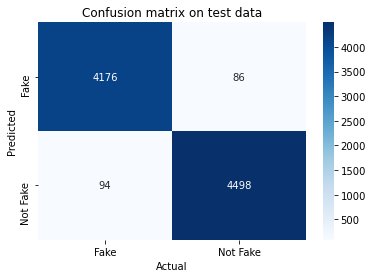

In [76]:
# plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import seaborn as sns

cm = pd.DataFrame(confusion_matrix(y_test , y_pred) , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Fake','Not Fake'], yticklabels = ['Fake','Not Fake'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.savefig('cf_word2vec_svm.jpg')
plt.show()